In [162]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy

In [163]:
#读取数据
data=pd.read_csv('./StudentsPerformance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [164]:
#查看表单数据
labels=['race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for label in labels:
    print(data[label].value_counts())
    print('*'*50)

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64
**************************************************
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64
**************************************************
standard        645
free/reduced    355
Name: lunch, dtype: int64
**************************************************
none         642
completed    358
Name: test preparation course, dtype: int64
**************************************************


In [165]:
#对成绩情况进行预处理
average=data[['math score', 'reading score', 'writing score']].mean(axis=1)
data.insert(8,'average score',np.round(average,decimals=2))
performance_level=pd.cut(data['average score'],bins=[0,60,70,80,90,100],labels=['F','D','C','B','A'])
data.insert(9,'performance level',performance_level)
data.sample(4)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score,performance level
787,female,group B,some college,standard,none,19,38,32,29.67,F
649,female,group D,some college,standard,completed,69,79,81,76.33,C
593,female,group E,high school,standard,none,74,76,73,74.33,C
925,male,group E,some high school,standard,completed,74,64,60,66.00,D


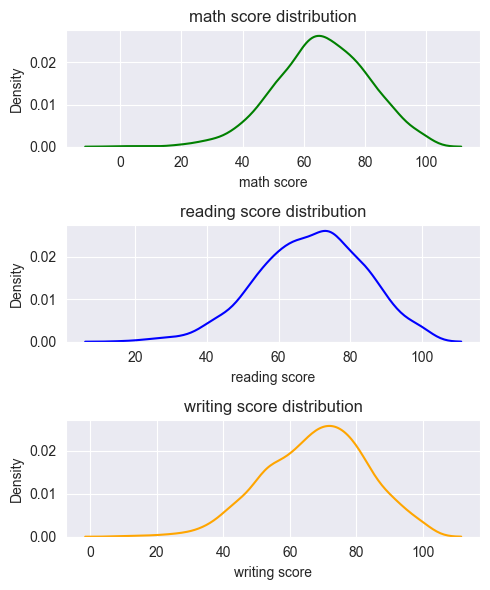

In [178]:
plt.figure(num='Score Distribution',figsize=(5,6))
sns.set_style('darkgrid')
subjects = ['math score', 'reading score', 'writing score']
color = ['green', 'blue', 'orange']
column = 1
for subject in subjects:
    plt.subplot(len(subjects), 1, column)
    sns.kdeplot(data=data, x=subject, color=color[column - 1])
    column = column + 1
    plt.title("{} distribution".format(subject))
plt.tight_layout()
plt.show()

In [167]:
#随机抽样的卡方检验(根据男女比例确定该抽样是否随机)
gender=data['gender'].unique()
expected_number=[500,500]
observed_number=data['gender'].value_counts().values.tolist()
result=stats.chisquare(f_obs=observed_number,f_exp=expected_number)
result[1]

0.25494516431731784

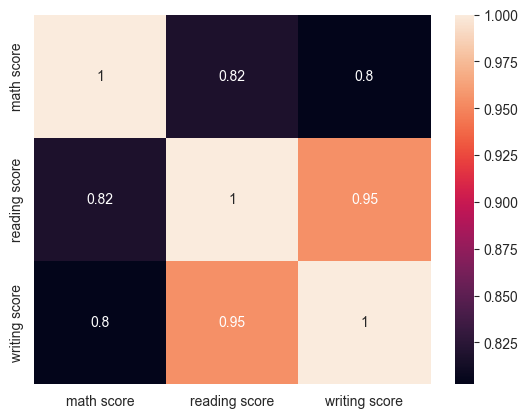

In [168]:
#成绩间的相关性
fig = plt.figure()
plt.subplot()
sns.heatmap(data[subjects].corr(), annot=True)
plt.show()

In [169]:
data.groupby('gender')[['math score']].agg([np.mean, np.median])

math score       
             mean median
gender                  
female  63.633205   65.0
male    68.728216   69.0

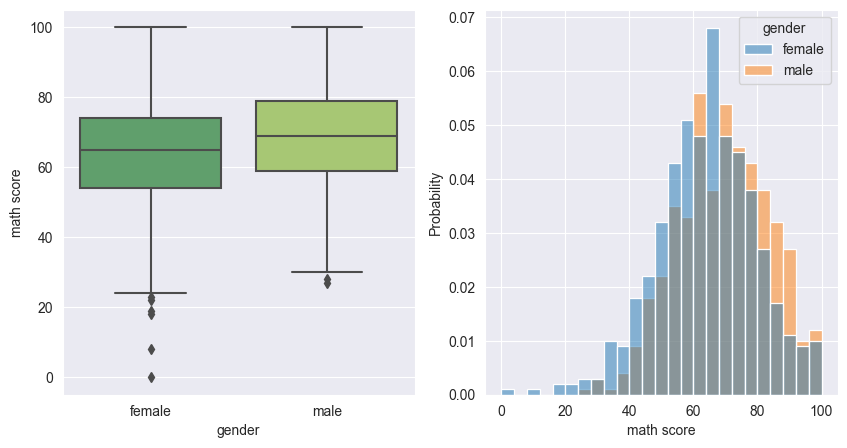

In [170]:
fig, ax  = plt.subplots(1,2, figsize=(10, 5))
sns.boxplot(data=data, y='math score', x='gender', palette='summer', ax=ax[0])
sns.histplot(data=data, x='math score', hue='gender', fill=True, ax=ax[1], stat='probability')
plt.show()

In [171]:
#检验学生数学成绩与性别间的关系
math_grading = pd.cut(data['math score'], bins=[0, 60, 70, 80, 90, 100],
                                   labels=['F', 'D', 'C', 'B', 'A'] )
crosstab = pd.crosstab(math_grading, data['gender'])
result = stats.chi2_contingency(crosstab)
result[1]

7.221116786466189e-05

In [172]:
data.groupby('gender')[['writing score']].agg([np.mean, np.median])
fig = px.histogram(
    data, x='writing score',
    marginal='box', opacity=0.6,
    color='gender',
    histnorm='probability',
    title='男生与女生在文科上的表现',
    template='plotly_white'
)

fig.update_layout(barmode='overlay', width=800)
fig.show()

In [173]:
# 检验学生成绩与父母受教育水平间的关系
honor_students = data.loc[data['average score'] >= 90]
honor_count = honor_students['parental level of education'].value_counts()
total_count = data['parental level of education'].value_counts()

fig = make_subplots(rows=1, cols=2, specs=[
                    [dict(type='domain'), {'type': 'domain'}]])

fig.add_pie(
    values=total_count.values, hole=0.4, labels=total_count.index,
    row=1, col=1, name='整体学生父母受教育程度'
)
fig.add_pie(
    values=honor_count.values, hole=0.4, labels=honor_count.index,
    row=1, col=2, name='高分学生父母受教育程度'
)

fig.update_layout(
    title_text="学生父母受教育程度",
    annotations=[dict(text='整体父母', x=0.15, y=0.5, font_size=20, showarrow=False),
                 dict(text='高分父母', x=0.85, y=0.5, font_size=20, showarrow=False)],
    width=900
)
fig.show()


In [174]:
#不同受教育水平父母的子女成绩均分
data.groupby('parental level of education')['average score'].mean().sort_values()

parental level of education
high school           63.097194
some high school      65.107654
some college          68.476106
associate's degree    69.568964
bachelor's degree     71.923983
master's degree       73.598644
Name: average score, dtype: float64

In [175]:
#检验父母受教育水平和子女成绩间的关系
crosstab = pd.crosstab(data['parental level of education'], data['performance level'])
result = stats.chi2_contingency(crosstab)
result[1]

9.624582920067994e-06

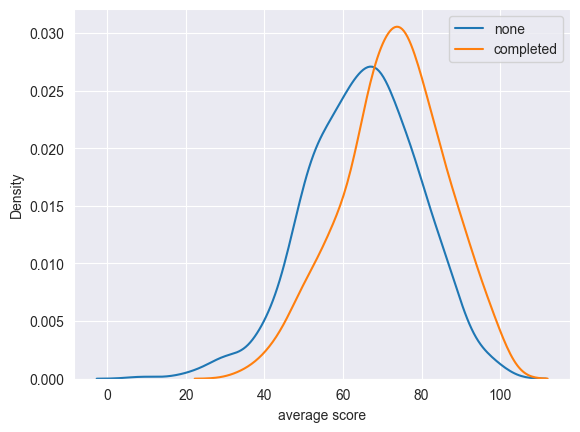

In [176]:
plt.figure(num='test preparation course')
conditions=['none','completed']
for condition in conditions:
    sns.kdeplot(data[data['test preparation course']==condition]['average score'],label=condition)
plt.legend()
plt.show()

In [177]:
crosstab = pd.crosstab(data['race/ethnicity'], data['performance level'])
result = stats.chi2_contingency(crosstab)
result[1]

0.00021324804101736277